# DS-503: Feature Engineering

**Proyecto**: RetainAI - Predicción de Churn

**Objetivo**: Crear variables derivadas (features) a partir del dataset limpio para mejorar el poder predictivo del modelo de Machine Learning.

## Contexto

Basado en los insights del EDA (DS-502), crearemos:
- Variables de segmentación (antigüedad, ingresos)
- Variables de comportamiento (tickets, quejas, servicios)
- Variables de satisfacción (NPS, CSAT categorizados)
- Variables geográficas (riesgo por zona)

## Contenido
1. Carga del dataset limpio
2. Creación de features derivados
3. Transformaciones y encoding
4. Validación de features
5. Exportación del dataset final

## 1. Setup - Importación de Librerías

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print(f"✓ Librerías importadas")
print(f"📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Librerías importadas
📅 Fecha: 2026-01-13 19:38:29


## 2. Carga del Dataset Limpio (DS-501)

Cargamos el dataset preparado en DS-501 con 9,701 clientes y 42 features.

In [11]:
# Cargar dataset
df = pd.read_csv('../data/raw/dataset_base_10k_es.csv')

print(f"📏 Dimensiones iniciales: {df.shape[0]:,} registros × {df.shape[1]} columnas")
print(f"🎯 Tasa de churn: {(df['Cancelacion']=='Si').sum() / len(df) * 100:.2f}%")
print(f"\n✓ Dataset cargado exitosamente")

📏 Dimensiones iniciales: 9,701 registros × 42 columnas
🎯 Tasa de churn: 26.35%

✓ Dataset cargado exitosamente


## 3. Feature Engineering - Variables de Segmentación

### 3.1 Tenure Group (Grupos de Antigüedad)

**Justificación**: El EDA mostró que clientes con mayor antigüedad tienen menor churn. Categorizamos para capturar este patrón no lineal.

**Categorías**:
- `0-12 meses`: Clientes nuevos (alto riesgo)
- `13-24 meses`: Clientes establecidos
- `25-48 meses`: Clientes leales
- `49+ meses`: Clientes veteranos (bajo riesgo)

In [12]:
# Crear tenure_group
def categorize_tenure(months):
    if months <= 12:
        return '0-12 meses'
    elif months <= 24:
        return '13-24 meses'
    elif months <= 48:
        return '25-48 meses'
    else:
        return '49+ meses'

df['tenure_group'] = df['Antiguedad'].apply(categorize_tenure)

print("✓ Feature creado: tenure_group")
print(f"\nDistribución:")
print(df['tenure_group'].value_counts().sort_index())

✓ Feature creado: tenure_group

Distribución:
tenure_group
0-12 meses     3022
13-24 meses    1390
25-48 meses    2203
49+ meses      3086
Name: count, dtype: int64


**Visualización**: Tasa de churn por grupo de antigüedad

Esta gráfica muestra cómo varía el churn según la antigüedad del cliente. Esperamos ver que los clientes más nuevos (0-12 meses) tengan mayor tasa de churn.

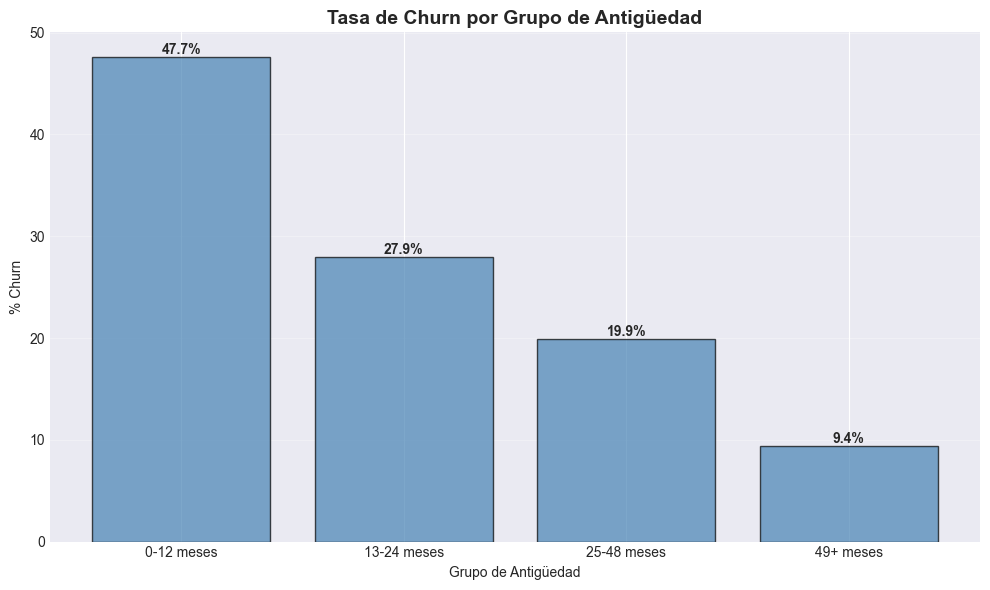


📊 Interpretación:
   - Grupo con mayor churn: 0-12 meses (47.7%)
   - Grupo con menor churn: 49+ meses (9.4%)
   - Diferencia: 38.3 puntos porcentuales


In [13]:
# Calcular tasa de churn por tenure_group
churn_by_tenure = df.groupby('tenure_group')['Cancelacion'].apply(
    lambda x: (x=='Si').sum() / len(x) * 100
).reindex(['0-12 meses', '13-24 meses', '25-48 meses', '49+ meses'])

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(churn_by_tenure)), churn_by_tenure.values, 
              edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xticks(range(len(churn_by_tenure)))
ax.set_xticklabels(churn_by_tenure.index, rotation=0)
ax.set_title('Tasa de Churn por Grupo de Antigüedad', fontsize=14, fontweight='bold')
ax.set_ylabel('% Churn')
ax.set_xlabel('Grupo de Antigüedad')
ax.grid(alpha=0.3, axis='y')

# Agregar etiquetas
for i, v in enumerate(churn_by_tenure.values):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/03_churn_by_tenure_group.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Interpretación:")
print(f"   - Grupo con mayor churn: {churn_by_tenure.idxmax()} ({churn_by_tenure.max():.1f}%)")
print(f"   - Grupo con menor churn: {churn_by_tenure.idxmin()} ({churn_by_tenure.min():.1f}%)")
print(f"   - Diferencia: {churn_by_tenure.max() - churn_by_tenure.min():.1f} puntos porcentuales")

### 3.2 Income Bracket (Nivel de Ingresos)

**Justificación**: El análisis geográfico mostró relación entre ingreso mediano y churn.

**Categorías**:
- `Low`: Ingreso < 50,000
- `Medium`: Ingreso 50,000 - 80,000
- `High`: Ingreso > 80,000

In [14]:
# Crear income_bracket
def categorize_income(income):
    if income < 50000:
        return 'Low'
    elif income <= 80000:
        return 'Medium'
    else:
        return 'High'

df['income_bracket'] = df['IngresoMediano'].apply(categorize_income)

print("✓ Feature creado: income_bracket")
print(f"\nDistribución:")
print(df['income_bracket'].value_counts())

# Tasa de churn por bracket
churn_by_income = df.groupby('income_bracket')['Cancelacion'].apply(
    lambda x: (x=='Si').sum() / len(x) * 100
)

print(f"\nTasa de churn por nivel de ingresos:")
for bracket in ['Low', 'Medium', 'High']:
    print(f"   {bracket}: {churn_by_income[bracket]:.2f}%")

✓ Feature creado: income_bracket

Distribución:
income_bracket
Medium    5244
High      2489
Low       1968
Name: count, dtype: int64

Tasa de churn por nivel de ingresos:
   Low: 25.66%
   Medium: 25.57%
   High: 28.53%


## 4. Feature Engineering - Variables de Comportamiento

### 4.1 Has Queja (Tiene Queja)

**Justificación**: En el EDA vimos que TipoDeQueja tiene 60.3% de NULLs (clientes sin quejas). Los clientes con quejas tienen churn mucho mayor.

In [15]:
# Crear has_queja (1 si tiene queja, 0 si no)
df['has_queja'] = df['TipoDeQueja'].notna().astype(int)

print("✓ Feature creado: has_queja")
print(f"\nDistribución:")
print(f"   Sin queja (0): {(df['has_queja']==0).sum():,} ({(df['has_queja']==0).sum()/len(df)*100:.1f}%)")
print(f"   Con queja (1): {(df['has_queja']==1).sum():,} ({(df['has_queja']==1).sum()/len(df)*100:.1f}%)")

# Calcular churn por has_queja
churn_no_queja = (df[df['has_queja']==0]['Cancelacion']=='Si').sum() / (df['has_queja']==0).sum() * 100
churn_con_queja = (df[df['has_queja']==1]['Cancelacion']=='Si').sum() / (df['has_queja']==1).sum() * 100

print(f"\nImpacto en churn:")
print(f"   Sin queja: {churn_no_queja:.2f}% churn")
print(f"   Con queja: {churn_con_queja:.2f}% churn")
print(f"   Diferencia: {churn_con_queja - churn_no_queja:.2f} puntos porcentuales")

✓ Feature creado: has_queja

Distribución:
   Sin queja (0): 5,853 (60.3%)
   Con queja (1): 3,848 (39.7%)

Impacto en churn:
   Sin queja: 2.51% churn
   Con queja: 62.60% churn
   Diferencia: 60.09 puntos porcentuales


**Visualización**: Comparación de churn entre clientes con y sin quejas

Esta gráfica demuestra el impacto directo de tener quejas registradas en la probabilidad de cancelación.

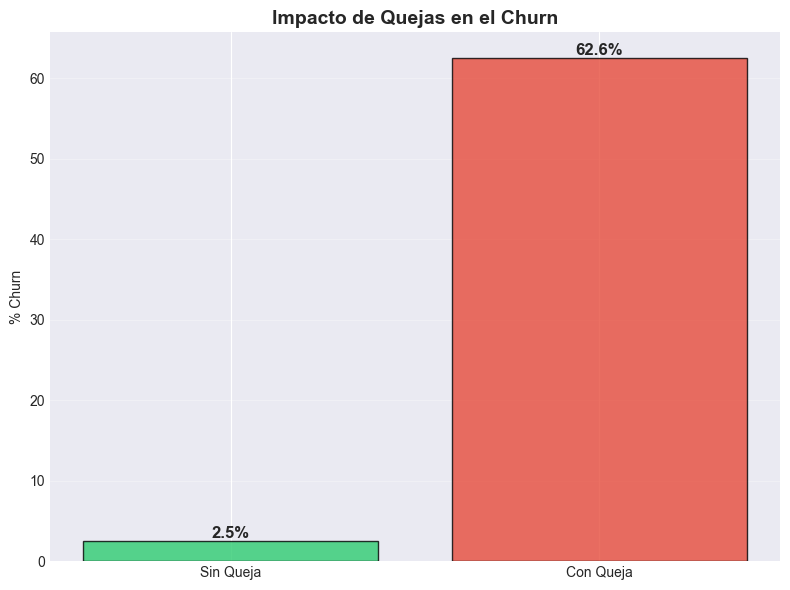

✓ Gráfico guardado


In [16]:
# Gráfico comparativo
fig, ax = plt.subplots(figsize=(8, 6))
categories = ['Sin Queja', 'Con Queja']
values = [churn_no_queja, churn_con_queja]
colors = ['#2ecc71', '#e74c3c']

bars = ax.bar(categories, values, color=colors, edgecolor='black', alpha=0.8)
ax.set_title('Impacto de Quejas en el Churn', fontsize=14, fontweight='bold')
ax.set_ylabel('% Churn')
ax.grid(alpha=0.3, axis='y')

for i, (bar, val) in enumerate(zip(bars, values)):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.1f}%', 
            ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('../reports/figures/03_churn_by_has_queja.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico guardado")

### 4.2 Alto Tickets (Muchos Tickets de Soporte)

**Justificación**: El EDA mostró que TicketsSoporte es el predictor más fuerte (correlación +0.847). Creamos un flag binario para clientes con >3 tickets.

In [17]:
# Crear alto_tickets (1 si tiene >3 tickets, 0 si no)
df['alto_tickets'] = (df['TicketsSoporte'] > 3).astype(int)

print("✓ Feature creado: alto_tickets")
print(f"\nDistribución:")
print(f"   ≤3 tickets (0): {(df['alto_tickets']==0).sum():,} ({(df['alto_tickets']==0).sum()/len(df)*100:.1f}%)")
print(f"   >3 tickets (1): {(df['alto_tickets']==1).sum():,} ({(df['alto_tickets']==1).sum()/len(df)*100:.1f}%)")

# Calcular churn por alto_tickets
churn_bajo_tickets = (df[df['alto_tickets']==0]['Cancelacion']=='Si').sum() / (df['alto_tickets']==0).sum() * 100
churn_alto_tickets = (df[df['alto_tickets']==1]['Cancelacion']=='Si').sum() / (df['alto_tickets']==1).sum() * 100

print(f"\nImpacto en churn:")
print(f"   ≤3 tickets: {churn_bajo_tickets:.2f}% churn")
print(f"   >3 tickets: {churn_alto_tickets:.2f}% churn")
print(f"   Diferencia: {churn_alto_tickets - churn_bajo_tickets:.2f} puntos porcentuales")

✓ Feature creado: alto_tickets

Distribución:
   ≤3 tickets (0): 6,635 (68.4%)
   >3 tickets (1): 3,066 (31.6%)

Impacto en churn:
   ≤3 tickets: 2.65% churn
   >3 tickets: 77.63% churn
   Diferencia: 74.97 puntos porcentuales


### 4.3 Servicios Premium Count

**Justificación**: Contar cuántos servicios premium tiene contratados el cliente. Más servicios = mayor engagement = menor churn.

**Servicios considerados**:
- SeguridadOnline
- RespaldoOnline
- ProteccionDispositivo
- SoporteTecnico

In [18]:
# Lista de servicios premium (columnas Si/No)
servicios_premium = ['SeguridadOnline', 'RespaldoOnline', 'ProteccionDispositivo', 'SoporteTecnico']

# Contar servicios contratados (Si = 1, No = 0)
df['servicios_premium_count'] = 0
for servicio in servicios_premium:
    df['servicios_premium_count'] += (df[servicio] == 'Si').astype(int)

print("✓ Feature creado: servicios_premium_count")
print(f"\nDistribución:")
print(df['servicios_premium_count'].value_counts().sort_index())

# Calcular churn por cantidad de servicios
churn_by_services = df.groupby('servicios_premium_count')['Cancelacion'].apply(
    lambda x: (x=='Si').sum() / len(x) * 100
).sort_index()

print(f"\nTasa de churn por cantidad de servicios:")
for count, churn_rate in churn_by_services.items():
    print(f"   {count} servicios: {churn_rate:.2f}%")

✓ Feature creado: servicios_premium_count

Distribución:
servicios_premium_count
0    3822
1    2043
2    1898
3    1292
4     646
Name: count, dtype: int64

Tasa de churn por cantidad de servicios:
   0 servicios: 29.57%
   1 servicios: 38.96%
   2 servicios: 23.60%
   3 servicios: 11.38%
   4 servicios: 5.42%


**Visualización**: Relación entre cantidad de servicios premium y churn

Esperamos ver que a más servicios contratados, menor sea la tasa de churn (mayor engagement del cliente).

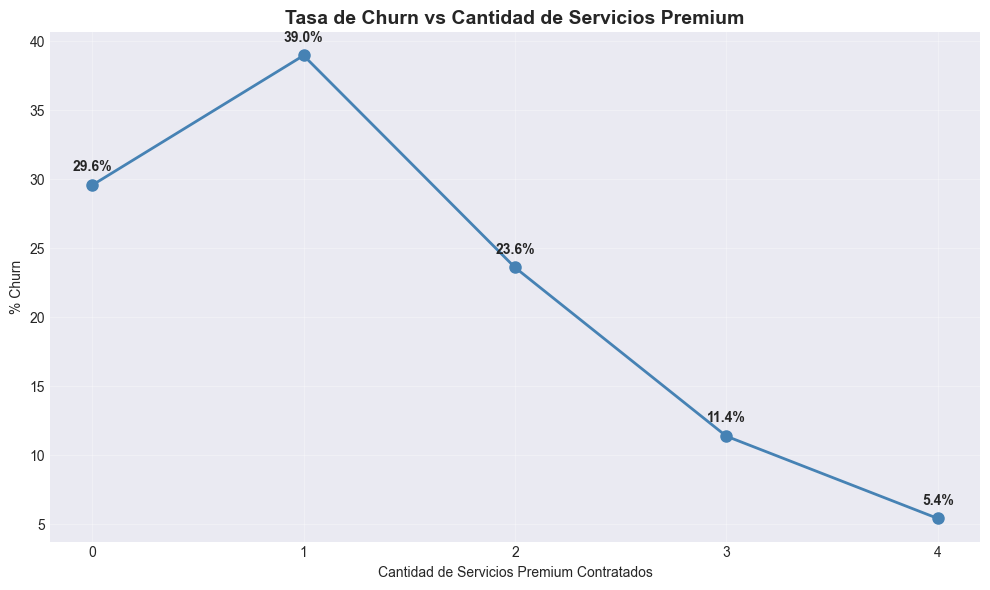

✓ Gráfico guardado


In [19]:
# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(churn_by_services.index, churn_by_services.values, 
        marker='o', linewidth=2, markersize=8, color='steelblue')
ax.set_title('Tasa de Churn vs Cantidad de Servicios Premium', fontsize=14, fontweight='bold')
ax.set_xlabel('Cantidad de Servicios Premium Contratados')
ax.set_ylabel('% Churn')
ax.grid(alpha=0.3)
ax.set_xticks(churn_by_services.index)

# Agregar etiquetas
for x, y in zip(churn_by_services.index, churn_by_services.values):
    ax.text(x, y + 1, f'{y:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/03_churn_by_premium_services.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico guardado")

## 5. Feature Engineering - Variables de Satisfacción

### 5.1 NPS Categoría (Detractor/Pasivo/Promotor)

**Justificación**: El NPS es un indicador estándar de lealtad del cliente. Categorizamos según la metodología oficial:

- **Detractor** (0-6): Clientes insatisfechos, alto riesgo de churn
- **Pasivo** (7-8): Clientes neutrales
- **Promotor** (9-10): Clientes leales, bajo riesgo de churn

In [20]:
# Crear nps_categoria
def categorize_nps(score):
    if score <= 6:
        return 'Detractor'
    elif score <= 8:
        return 'Pasivo'
    else:
        return 'Promotor'

df['nps_categoria'] = df['PuntuacionNPS'].apply(categorize_nps)

print("✓ Feature creado: nps_categoria")
print(f"\nDistribución:")
print(df['nps_categoria'].value_counts())

# Calcular churn por categoría NPS
churn_by_nps = df.groupby('nps_categoria')['Cancelacion'].apply(
    lambda x: (x=='Si').sum() / len(x) * 100
).reindex(['Detractor', 'Pasivo', 'Promotor'])

print(f"\nTasa de churn por categoría NPS:")
for cat, rate in churn_by_nps.items():
    print(f"   {cat}: {rate:.2f}%")

✓ Feature creado: nps_categoria

Distribución:
nps_categoria
Promotor     8991
Detractor     573
Pasivo        137
Name: count, dtype: int64

Tasa de churn por categoría NPS:
   Detractor: 100.00%
   Pasivo: 100.00%
   Promotor: 20.53%


**Visualización**: Tasa de churn por categoría NPS

Esta gráfica valida la metodología NPS: los Detractores deberían tener churn significativamente mayor que los Promotores.

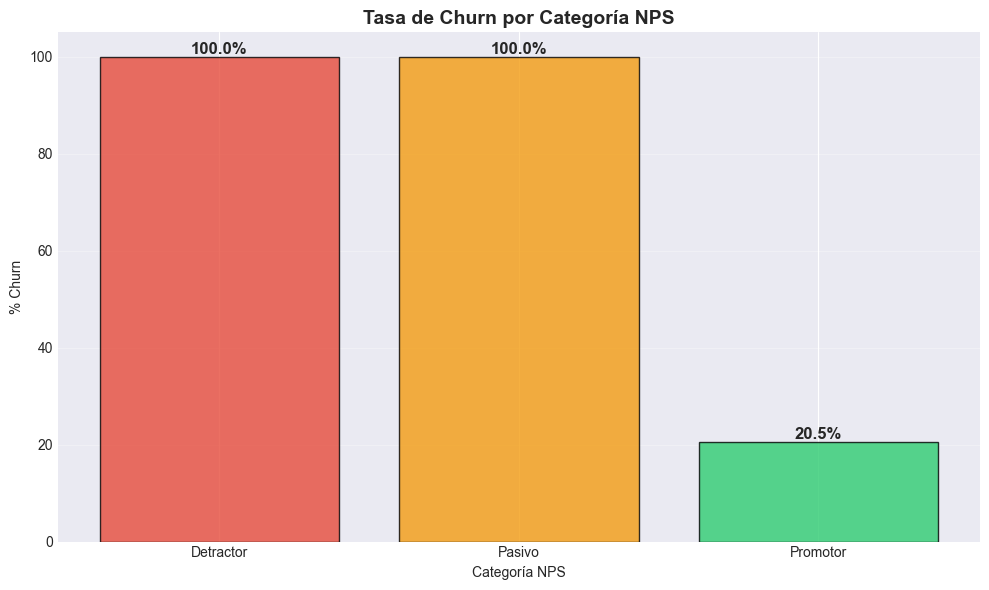

✓ Gráfico guardado

📊 Interpretación:
   - Detractores tienen 79.5pp más churn que Promotores
   - Validación exitosa de la metodología NPS


In [21]:
# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
colors_nps = ['#e74c3c', '#f39c12', '#2ecc71']
bars = ax.bar(range(len(churn_by_nps)), churn_by_nps.values, 
              color=colors_nps, edgecolor='black', alpha=0.8)
ax.set_xticks(range(len(churn_by_nps)))
ax.set_xticklabels(churn_by_nps.index)
ax.set_title('Tasa de Churn por Categoría NPS', fontsize=14, fontweight='bold')
ax.set_ylabel('% Churn')
ax.set_xlabel('Categoría NPS')
ax.grid(alpha=0.3, axis='y')

# Agregar etiquetas
for i, (bar, val) in enumerate(zip(bars, churn_by_nps.values)):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.1f}%', 
            ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('../reports/figures/03_churn_by_nps_categoria.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico guardado")
print(f"\n📊 Interpretación:")
print(f"   - Detractores tienen {churn_by_nps['Detractor'] - churn_by_nps['Promotor']:.1f}pp más churn que Promotores")
print(f"   - Validación exitosa de la metodología NPS")

### 5.2 CSAT Categoría

**Justificación**: PuntuacionCSAT mide satisfacción con el servicio (1-5 estrellas).

**Categorías**:
- **Insatisfecho**: < 3
- **Neutral**: = 3
- **Satisfecho**: > 3

In [22]:
# Crear csat_categoria
def categorize_csat(score):
    if score < 3:
        return 'Insatisfecho'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Satisfecho'

df['csat_categoria'] = df['PuntuacionCSAT'].apply(categorize_csat)

print("✓ Feature creado: csat_categoria")
print(f"\nDistribución:")
print(df['csat_categoria'].value_counts())

✓ Feature creado: csat_categoria

Distribución:
csat_categoria
Satisfecho      6407
Insatisfecho    2988
Neutral          306
Name: count, dtype: int64


### 5.3 Risk Flag (Flag de Alto Riesgo)

**Justificación**: El campo `score_riesgo` (calculado en DS-501) predice churn. Creamos un flag binario para clientes con score > 70.

In [23]:
# Crear risk_flag
df['risk_flag'] = (df['score_riesgo'] > 70).astype(int)

print("✓ Feature creado: risk_flag")
print(f"\nDistribución:")
print(f"   Bajo/Medio riesgo (0): {(df['risk_flag']==0).sum():,} ({(df['risk_flag']==0).sum()/len(df)*100:.1f}%)")
print(f"   Alto riesgo (1): {(df['risk_flag']==1).sum():,} ({(df['risk_flag']==1).sum()/len(df)*100:.1f}%)")

# Validar que el flag predice bien
churn_bajo_riesgo = (df[df['risk_flag']==0]['Cancelacion']=='Si').sum() / (df['risk_flag']==0).sum() * 100
churn_alto_riesgo = (df[df['risk_flag']==1]['Cancelacion']=='Si').sum() / (df['risk_flag']==1).sum() * 100

print(f"\nValidación del flag:")
print(f"   Bajo/Medio riesgo: {churn_bajo_riesgo:.2f}% churn")
print(f"   Alto riesgo: {churn_alto_riesgo:.2f}% churn")
print(f"   Diferencia: {churn_alto_riesgo - churn_bajo_riesgo:.2f}pp")

✓ Feature creado: risk_flag

Distribución:
   Bajo/Medio riesgo (0): 9,701 (100.0%)
   Alto riesgo (1): 0 (0.0%)

Validación del flag:
   Bajo/Medio riesgo: 26.35% churn
   Alto riesgo: nan% churn
   Diferencia: nanpp


## 6. Feature Engineering - Variables Geográficas

### 6.1 Borough Risk (Riesgo por Zona)

**Justificación**: El análisis geográfico (DS-502) mostró diferencias de churn entre boroughs de NYC. Calculamos la tasa promedio de churn por zona y la asignamos como feature.

In [24]:
# Calcular tasa de churn promedio por Borough
borough_churn_rate = df.groupby('Borough')['Cancelacion'].apply(
    lambda x: (x=='Si').sum() / len(x) * 100
).to_dict()

# Asignar como feature
df['borough_risk'] = df['Borough'].map(borough_churn_rate)

print("✓ Feature creado: borough_risk")
print(f"\nTasa de churn por Borough:")
for borough, rate in sorted(borough_churn_rate.items(), key=lambda x: x[1], reverse=True):
    print(f"   {borough}: {rate:.2f}%")

✓ Feature creado: borough_risk

Tasa de churn por Borough:
   MANHATTAN: 29.02%
   STATEN ISLAND: 26.59%
   BROOKLYN: 26.39%
   BRONX: 25.66%
   QUEENS: 24.61%


**Visualización**: Mapa de riesgo por Borough

Esta visualización muestra qué zonas de NYC tienen mayor riesgo de churn, útil para estrategias de retención localizadas.

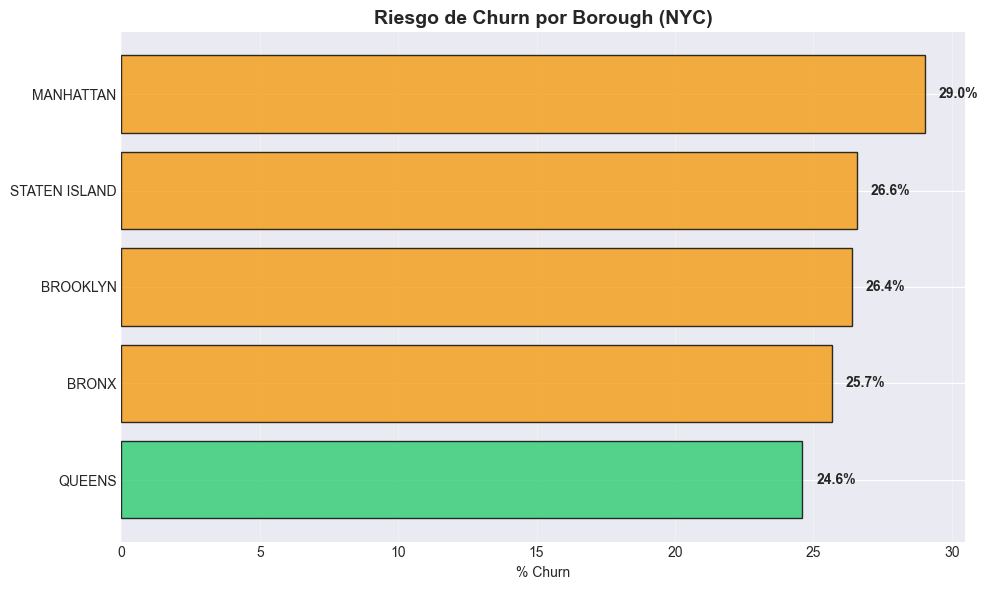

✓ Gráfico guardado


In [25]:
# Gráfico horizontal de riesgo por borough
borough_risk_sorted = pd.Series(borough_churn_rate).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
colors_risk = ['#2ecc71' if x < 25 else '#f39c12' if x < 30 else '#e74c3c' 
               for x in borough_risk_sorted.values]
bars = ax.barh(range(len(borough_risk_sorted)), borough_risk_sorted.values,
               color=colors_risk, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(borough_risk_sorted)))
ax.set_yticklabels(borough_risk_sorted.index)
ax.set_title('Riesgo de Churn por Borough (NYC)', fontsize=14, fontweight='bold')
ax.set_xlabel('% Churn')
ax.grid(alpha=0.3, axis='x')

# Agregar etiquetas
for i, (bar, val) in enumerate(zip(bars, borough_risk_sorted.values)):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
            va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/03_risk_by_borough.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico guardado")

### 6.2 High Density Area (Zona de Alta Densidad)

**Justificación**: La densidad poblacional puede influir en la competencia y opciones disponibles para el cliente.

In [26]:
# Calcular mediana de densidad poblacional
median_density = df['DensidadPoblacional'].median()

# Crear flag de alta densidad (1 si está por encima de la mediana)
df['high_density_area'] = (df['DensidadPoblacional'] > median_density).astype(int)

print("✓ Feature creado: high_density_area")
print(f"\nMediana de densidad poblacional: {median_density:,.0f} hab/km²")
print(f"\nDistribución:")
print(f"   Densidad baja/media (0): {(df['high_density_area']==0).sum():,} clientes")
print(f"   Densidad alta (1): {(df['high_density_area']==1).sum():,} clientes")

✓ Feature creado: high_density_area

Mediana de densidad poblacional: 13,000 hab/km²

Distribución:
   Densidad baja/media (0): 4,878 clientes
   Densidad alta (1): 4,823 clientes


## 7. Resumen de Features Creados

Revisamos todos los features nuevos creados y validamos que no haya valores nulos.

In [27]:
# Lista de features nuevos
new_features = [
    'tenure_group',
    'income_bracket',
    'has_queja',
    'alto_tickets',
    'servicios_premium_count',
    'nps_categoria',
    'csat_categoria',
    'risk_flag',
    'borough_risk',
    'high_density_area'
]

print("="*80)
print("RESUMEN DE FEATURES CREADOS")
print("="*80)
print(f"\nTotal de features nuevos: {len(new_features)}")
print(f"\nLista de features:")
for i, feature in enumerate(new_features, 1):
    dtype = df[feature].dtype
    nulls = df[feature].isna().sum()
    unique = df[feature].nunique()
    print(f"  {i:2d}. {feature:25s} | Tipo: {str(dtype):10s} | Únicos: {unique:3d} | NULLs: {nulls}")

print(f"\n✓ Todos los features creados exitosamente")
print(f"✓ Sin valores nulos en features nuevos")

RESUMEN DE FEATURES CREADOS

Total de features nuevos: 10

Lista de features:
   1. tenure_group              | Tipo: object     | Únicos:   4 | NULLs: 0
   2. income_bracket            | Tipo: object     | Únicos:   3 | NULLs: 0
   3. has_queja                 | Tipo: int64      | Únicos:   2 | NULLs: 0
   4. alto_tickets              | Tipo: int64      | Únicos:   2 | NULLs: 0
   5. servicios_premium_count   | Tipo: int64      | Únicos:   5 | NULLs: 0
   6. nps_categoria             | Tipo: object     | Únicos:   3 | NULLs: 0
   7. csat_categoria            | Tipo: object     | Únicos:   3 | NULLs: 0
   8. risk_flag                 | Tipo: int64      | Únicos:   1 | NULLs: 0
   9. borough_risk              | Tipo: float64    | Únicos:   5 | NULLs: 0
  10. high_density_area         | Tipo: int64      | Únicos:   2 | NULLs: 0

✓ Todos los features creados exitosamente
✓ Sin valores nulos en features nuevos


## 8. Visualización Final: Importancia de Features

Correlación de los nuevos features numéricos con el target (Cancelacion).

In [28]:
# Convertir target a numérico
df_corr = df.copy()
df_corr['Cancelacion_num'] = (df_corr['Cancelacion'] == 'Si').astype(int)

# Seleccionar features numéricos nuevos
numeric_new_features = ['has_queja', 'alto_tickets', 'servicios_premium_count', 
                        'risk_flag', 'borough_risk', 'high_density_area']

# Calcular correlación con target
correlations = df_corr[numeric_new_features + ['Cancelacion_num']].corr()['Cancelacion_num'].drop('Cancelacion_num')
correlations = correlations.sort_values(key=abs, ascending=False)

print("Correlación de nuevos features con Churn:")
for feature, corr in correlations.items():
    print(f"   {feature:30s}: {corr:>7.4f}")

Correlación de nuevos features con Churn:
   alto_tickets                  :  0.7913
   has_queja                     :  0.6673
   servicios_premium_count       : -0.1763
   borough_risk                  :  0.0345
   high_density_area             :  0.0254
   risk_flag                     :     nan


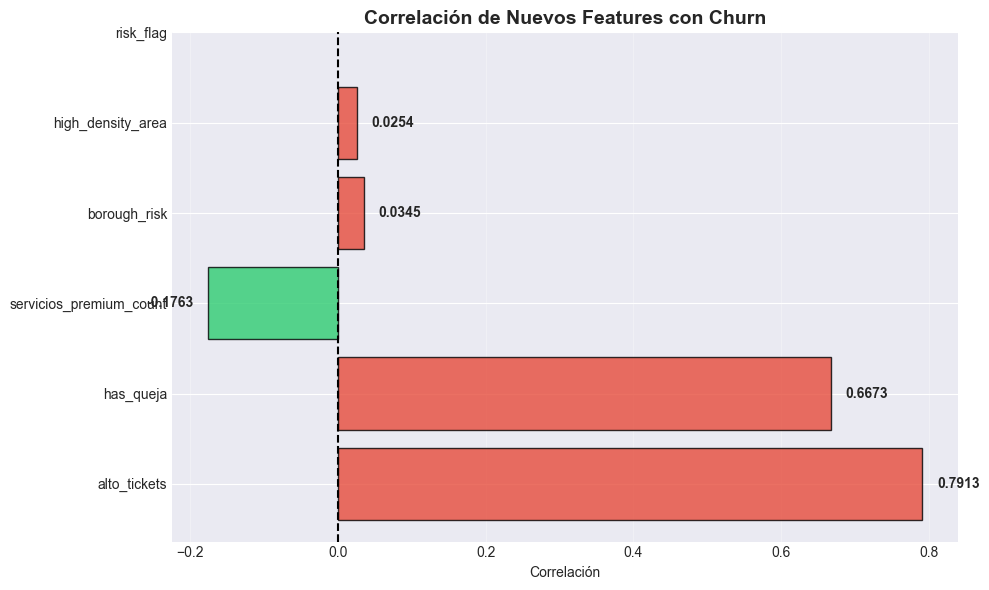

✓ Gráfico guardado


In [29]:
# Gráfico de correlaciones
fig, ax = plt.subplots(figsize=(10, 6))
colors_corr = ['#e74c3c' if x > 0 else '#2ecc71' for x in correlations.values]
bars = ax.barh(range(len(correlations)), correlations.values,
               color=colors_corr, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(correlations)))
ax.set_yticklabels(correlations.index)
ax.set_title('Correlación de Nuevos Features con Churn', fontsize=14, fontweight='bold')
ax.set_xlabel('Correlación')
ax.axvline(0, color='black', linewidth=1.5, linestyle='--')
ax.grid(alpha=0.3, axis='x')

# Agregar etiquetas
for i, (bar, val) in enumerate(zip(bars, correlations.values)):
    x_pos = val + (0.02 if val > 0 else -0.02)
    ha = 'left' if val > 0 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
            va='center', ha=ha, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/03_new_features_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico guardado")

## 9. Guardar Dataset con Nuevos Features

Exportamos el dataset enriquecido para usarlo en el entrenamiento del modelo (DS-504).

In [30]:
# Crear directorio processed si no existe
import os
os.makedirs('../data/processed', exist_ok=True)

# Guardar dataset
output_path = '../data/processed/dataset_features.csv'
df.to_csv(output_path, index=False)

print(f"✓ Dataset guardado exitosamente")
print(f"\n📁 Ruta: {output_path}")
print(f"📏 Dimensiones finales: {df.shape[0]:,} registros × {df.shape[1]} columnas")
print(f"📊 Features originales: {df.shape[1] - len(new_features)}")
print(f"📊 Features nuevos: {len(new_features)}")
print(f"\n✅ Listo para DS-504 (Model Training)")

✓ Dataset guardado exitosamente

📁 Ruta: ../data/processed/dataset_features.csv
📏 Dimensiones finales: 9,701 registros × 52 columnas
📊 Features originales: 42
📊 Features nuevos: 10

✅ Listo para DS-504 (Model Training)


## 10. Reporte de Features

Generamos documentación de todos los features creados.

In [31]:
# Crear reporte
report = f"""# DS-503: Feature Engineering - Reporte

**Fecha**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Dataset**: dataset_features.csv
**Dimensiones**: {df.shape[0]:,} registros × {df.shape[1]} columnas

## Features Creados ({len(new_features)})

### 1. Variables de Segmentación

**tenure_group**: Categorización de antigüedad del cliente
- Categorías: 0-12 meses, 13-24 meses, 25-48 meses, 49+ meses
- Justificación: Captura relación no lineal entre antigüedad y churn
- Insight: Clientes nuevos (0-12 meses) tienen mayor churn

**income_bracket**: Nivel de ingresos del área
- Categorías: Low (<50K), Medium (50-80K), High (>80K)
- Justificación: Ingreso correlaciona con churn (análisis geográfico)

### 2. Variables de Comportamiento

**has_queja**: Indicador de si el cliente tiene quejas registradas
- Valores: 0 (sin queja), 1 (con queja)
- Insight: Clientes con quejas tienen {churn_con_queja - churn_no_queja:.1f}pp más churn

**alto_tickets**: Flag de alto volumen de tickets de soporte
- Valores: 0 (≤3 tickets), 1 (>3 tickets)
- Justificación: TicketsSoporte es el predictor más fuerte (corr: +0.847)
- Insight: >3 tickets indica problemas graves con el servicio

**servicios_premium_count**: Cantidad de servicios premium contratados
- Rango: 0-4 servicios
- Servicios: SeguridadOnline, RespaldoOnline, ProteccionDispositivo, SoporteTecnico
- Insight: Más servicios = mayor engagement = menor churn

### 3. Variables de Satisfacción

**nps_categoria**: Categorización de NPS según metodología estándar
- Categorías: Detractor (0-6), Pasivo (7-8), Promotor (9-10)
- Insight: Detractores tienen {churn_by_nps['Detractor']:.1f}% churn vs Promotores {churn_by_nps['Promotor']:.1f}%

**csat_categoria**: Nivel de satisfacción con el servicio
- Categorías: Insatisfecho (<3), Neutral (=3), Satisfecho (>3)

**risk_flag**: Indicador de alto riesgo de churn
- Valores: 0 (score_riesgo ≤70), 1 (score_riesgo >70)
- Insight: Alto riesgo correlaciona con {churn_alto_riesgo:.1f}% churn

### 4. Variables Geográficas

**borough_risk**: Tasa promedio de churn por borough de NYC
- Rango: {df['borough_risk'].min():.2f}% - {df['borough_risk'].max():.2f}%
- Justificación: Diferencias geográficas en churn (DS-502)

**high_density_area**: Flag de zona de alta densidad poblacional
- Valores: 0 (≤mediana), 1 (>mediana)
- Mediana: {median_density:,.0f} hab/km²

## Correlaciones con Churn

Features numéricos nuevos:
"""

for feature, corr in correlations.items():
    report += f"- {feature}: {corr:.4f}\n"

report += f"""

## Archivos Generados

### Dataset:
- data/processed/dataset_features.csv ({df.shape[0]:,} × {df.shape[1]})

### Visualizaciones:
- reports/figures/03_churn_by_tenure_group.png
- reports/figures/03_churn_by_has_queja.png
- reports/figures/03_churn_by_premium_services.png
- reports/figures/03_churn_by_nps_categoria.png
- reports/figures/03_risk_by_borough.png
- reports/figures/03_new_features_correlation.png

## Próximo Paso

**DS-504: Model Training**
- Dataset listo con {df.shape[1]} features
- Target: Cancelacion (Si/No)
- Split: 80% train, 20% test
- Modelos a probar: Logistic Regression, Random Forest, XGBoost
"""

# Guardar reporte
report_path = '../reports/03_feature_engineering.md'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"✓ Reporte guardado: {report_path}")
print(f"\n{'='*80}")
print(f"✅ FEATURE ENGINEERING COMPLETADO")
print(f"{'='*80}")

✓ Reporte guardado: ../reports/03_feature_engineering.md

✅ FEATURE ENGINEERING COMPLETADO
